## Time Series Analysis

### Agenda
   
    ♦ Problem Description
    ♦ Data Understanding
    ♦ Basic data Pre-processing
    ♦ Time-Series related Pre-processing
    ♦ Time-Series Data Aggregation 
    ♦ Data split: train and validation sets
    ♦ Creating Time-Series Object
    ♦ Moving Averages
    ♦ ETS Models
    ♦ ARIMA

## Problem Statement

A multinational e-commerce company idenified a segment of products which are showing less sales when comapred to other class of products. 

As the prices of those products are volatile periodically, based on demand and other economic factors, if they timely quote right price then the chance of increasing sales is very high. 

They want to understand what is right price to quote on a given period for each product which will help them to increase the sales. 

#### The given data contains historical data of a product. Perform time series analysis and forecast the price.

In [1]:
library(zoo) 
library(dplyr)
library(TTR) 
library(forecast)
library(DMwR)
library(tseries)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: lattice

Loading required package: grid



In [2]:
options(repr.plot.width = 20, repr.plot.height = 8)

## Data Understanding

In [3]:
sku_data = readRDS("Data.rds")

#### Dimension of the Data set

In [4]:
dim(sku_data)

[1] 19657     3

#### Look at the descriptive statistics

In [5]:
str(sku_data)
summary(sku_data)

Classes ‘data.table’ and 'data.frame':	19657 obs. of  3 variables:
 $ SKU  : num  1 2 3 1 2 2 2 1 1 2 ...
 $ Price: num  130 58 84.4 160 57 ...
 $ Date : chr  "2009-06-01" "2009-06-01" "2009-12-08" "2009-12-08" ...
 - attr(*, ".internal.selfref")=<externalptr> 


      SKU            Price            Date          
 Min.   :1.000   Min.   : 20.27   Length:19657      
 1st Qu.:1.000   1st Qu.: 50.15   Class :character  
 Median :2.000   Median : 70.97   Mode  :character  
 Mean   :1.942   Mean   : 80.63                     
 3rd Qu.:3.000   3rd Qu.:105.00                     
 Max.   :3.000   Max.   :999.00                     

#### Look at the first and last 6 records using head and tail commands

In [6]:
head(sku_data, 6)

,SKU,Price,Date
,<dbl>,<dbl>,<chr>
1,1,129.98,2009-06-01
2,2,57.96,2009-06-01
3,3,84.38,2009-12-08
4,1,159.96,2009-12-08
5,2,56.98,2009-12-08
6,2,58.38,2009-12-08


In [7]:
tail(sku_data, 6)

SKU,Price,Date
<dbl>,<dbl>,<chr>
3,79.62,2013-08-09
2,39.68,2013-08-09
3,78.00,2013-08-09
3,79.62,2013-08-09
3,79.62,2013-08-09
2,38.99,2013-08-09


#### Get the unique levels and their counts in SKU attribute

In [8]:
table(sku_data$SKU)


   1    2    3 
6997 6812 5848 

## Basic Pre-processing

#### Convert attributes into appropriate type

In [9]:
sku_data$SKU = as.factor(sku_data$SKU)
sku_data$Date = as.Date(sku_data$Date, format="%Y-%m-%d")

In [10]:
# Re-look at the first 6 records
head(sku_data)

# Summary of the data
summary(sku_data)

SKU,Price,Date
<fct>,<dbl>,<date>
1,129.98,2009-06-01
2,57.96,2009-06-01
3,84.38,2009-12-08
1,159.96,2009-12-08
2,56.98,2009-12-08
2,58.38,2009-12-08


 SKU          Price             Date           
 1:6997   Min.   : 20.27   Min.   :2009-03-06  
 2:6812   1st Qu.: 50.15   1st Qu.:2010-10-22  
 3:5848   Median : 70.97   Median :2011-11-06  
          Mean   : 80.63   Mean   :2011-10-25  
          3rd Qu.:105.00   3rd Qu.:2012-11-26  
          Max.   :999.00   Max.   :2013-12-02  

#### Drop rows where Price is 999

In [11]:
## Check the number of rows where Price is 999 
nrow(sku_data[sku_data$Price == 999 ,])

## Drop the row where Price is 999
sku_data = sku_data[sku_data$Price != 999 ,]

## Check summary after dropping the row
summary(sku_data)

[1] 1

 SKU          Price             Date           
 1:6997   Min.   : 20.27   Min.   :2009-03-06  
 2:6812   1st Qu.: 50.15   1st Qu.:2010-10-22  
 3:5847   Median : 70.96   Median :2011-11-06  
          Mean   : 80.58   Mean   :2011-10-25  
          3rd Qu.:105.00   3rd Qu.:2012-11-26  
          Max.   :487.72   Max.   :2013-12-02  

## Time-Series related Pre-processing

In [12]:
# Focusing on a particular product of choice (Let's use only SKU code 3 for analysis)
data = sku_data[sku_data$SKU == 3, ]

# Basic info about that product
summary(data)

 SKU          Price             Date           
 1:   0   Min.   : 39.84   Min.   :2009-04-15  
 2:   0   1st Qu.: 60.00   1st Qu.:2011-01-26  
 3:5847   Median : 72.25   Median :2012-03-01  
          Mean   : 73.14   Mean   :2011-12-31  
          3rd Qu.: 83.75   3rd Qu.:2013-01-08  
          Max.   :379.80   Max.   :2013-12-02  

In [13]:
# As all records has same SKU, it can be removed
data$SKU = NULL

# Sort the Data in increasing order of date
data = data[order(data$Date, decreasing = F), ]

head(data)

Price,Date
<dbl>,<date>
58.65,2009-04-15
79.64,2009-04-16
58.65,2009-04-16
79.64,2009-04-17
58.65,2009-04-17
79.64,2009-04-18


## Handle Duplicates

On the given date, product has multiple prices, so one way is to consider the min price.

In [14]:
# library(dplyr)

data = data %>% group_by(Date) %>% summarise("MinPrice" = min(Price)) %>% data.frame()
head(data)

`summarise()` ungrouping output (override with `.groups` argument)



,Date,MinPrice
,<date>,<dbl>
1,2009-04-15,58.65
2,2009-04-16,58.65
3,2009-04-17,58.65
4,2009-04-18,79.64
5,2009-05-30,115.98
6,2009-05-31,115.98


## Handle missing dates

In [15]:
minDate = min(data$Date)
maxDate = max(data$Date)

maxDate - minDate
nrow(data)

Time difference of 1692 days

[1] 1502

In [16]:
data = data.frame("DateRange" = seq(minDate, maxDate, by = "days")) %>% 
            full_join(data, c("DateRange" = "Date")) %>% 
            data.frame()

head(data,10)

,DateRange,MinPrice
,<date>,<dbl>
1,2009-04-15,58.65
2,2009-04-16,58.65
3,2009-04-17,58.65
4,2009-04-18,79.64
5,2009-04-19,NA
6,2009-04-20,NA
7,2009-04-21,NA
8,2009-04-22,NA
9,2009-04-23,NA


In [17]:
# Imputation

# library(zoo)

# na.locf function is used to replace the missing values. 
# This will replace the missing value with the it's immediate preceding value. 

data$MinPrice = (na.locf(data$MinPrice, fromLast = F) + na.locf(data$MinPrice, fromLast = T))/2

head(data)

,DateRange,MinPrice
,<date>,<dbl>
1,2009-04-15,58.65
2,2009-04-16,58.65
3,2009-04-17,58.65
4,2009-04-18,79.64
5,2009-04-19,97.81
6,2009-04-20,97.81


### Demo of "na.locf()"  function

In [18]:
x <- c(2, 5, NA, NA, NA, 7, 11)
x

na.locf(x)

na.locf(x, fromLast = T)

# if you want to replace the missing value with average value of its immediate neighbors
(na.locf(x) + na.locf(x, fromLast = T))/2

rm(x)

[1]  2  5 NA NA NA  7 11

[1]  2  5  5  5  5  7 11

[1]  2  5  7  7  7  7 11

[1]  2  5  6  6  6  7 11

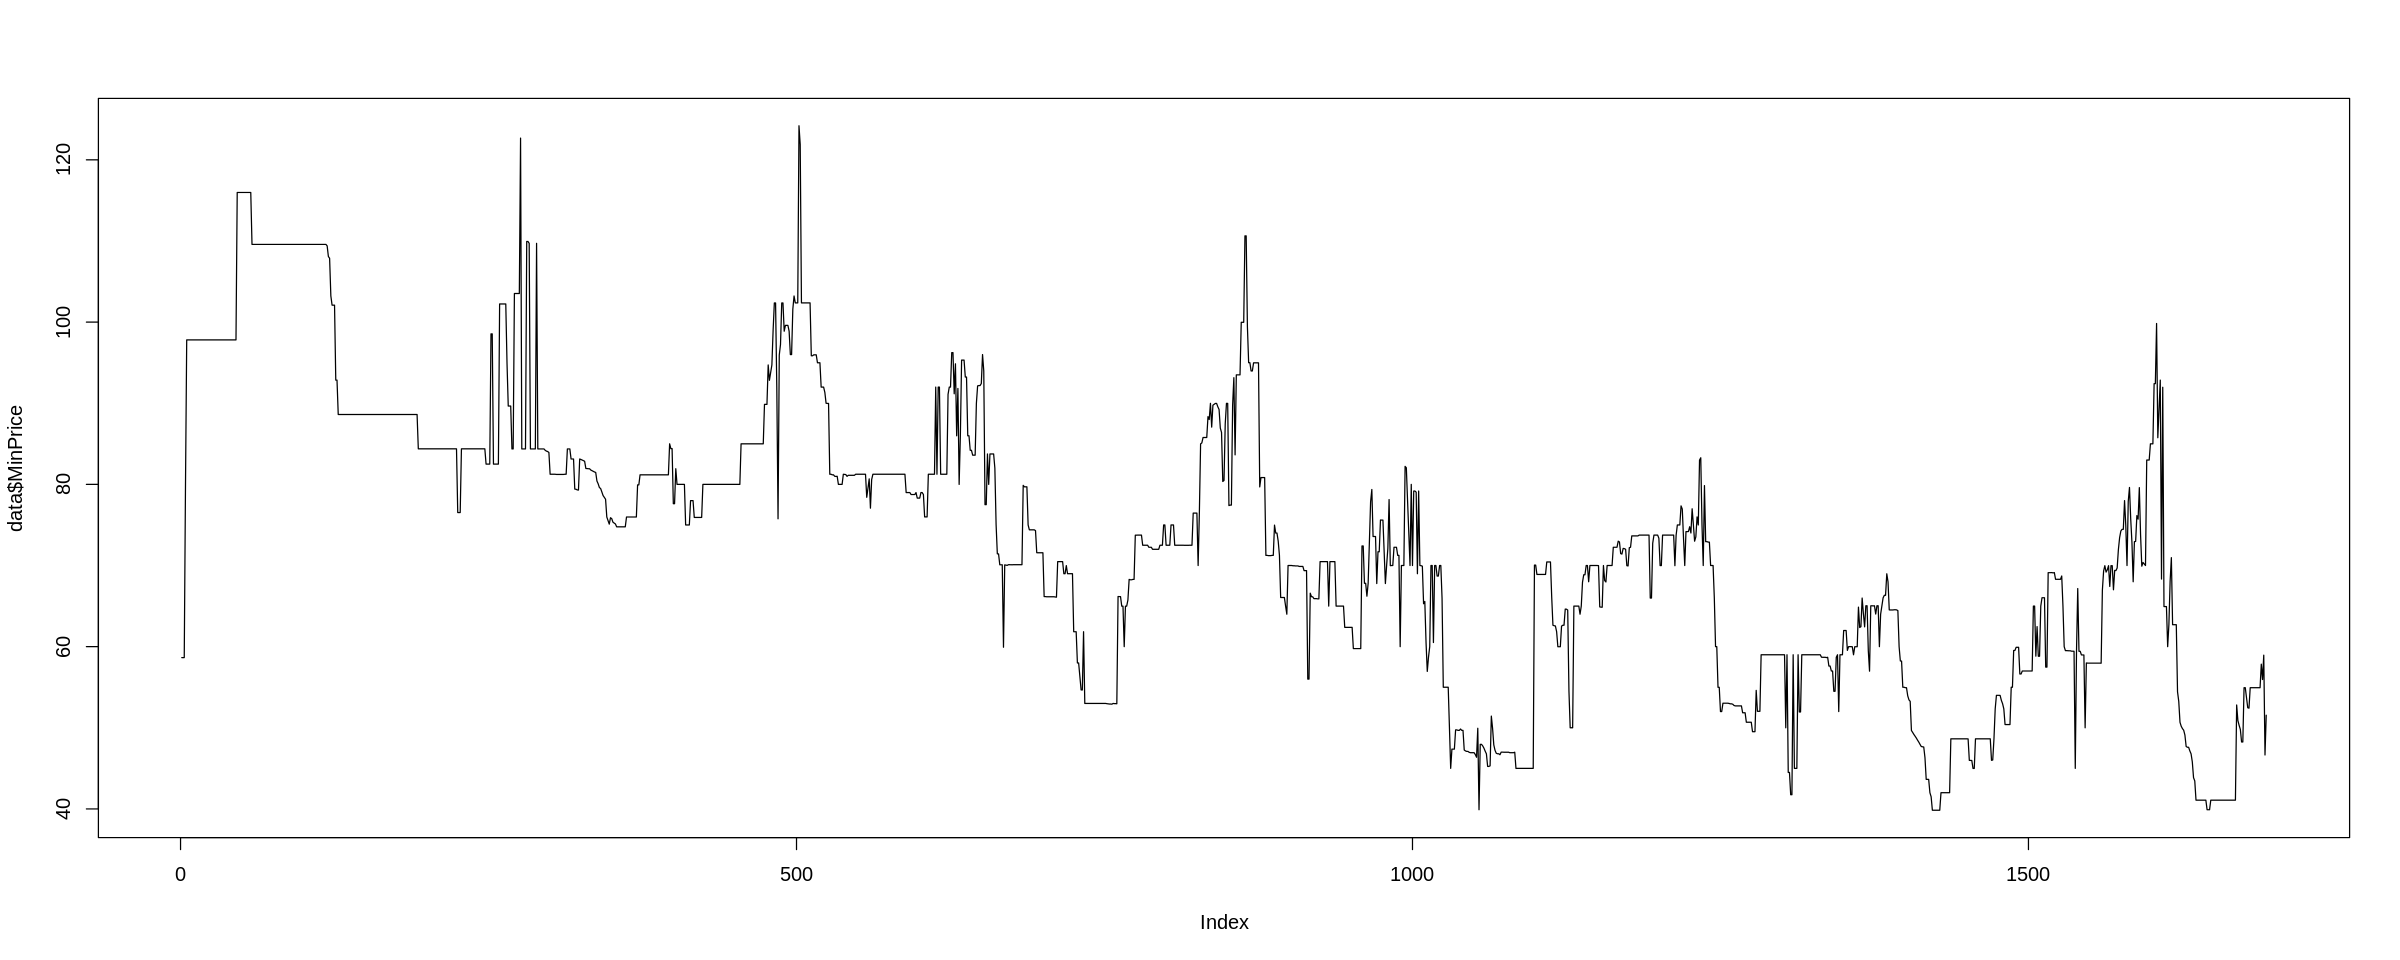

In [19]:
plot(data$MinPrice, type = 'l')

## Time-Series Data Aggregation 

Aggregate Data at month level from day level

In [20]:
# Derive Year and Month attribute 
data$Year = as.numeric(format(data$DateRange, format = "%Y"))
data$Month = as.numeric(format(data$DateRange, format = "%m"))

head(data)

,DateRange,MinPrice,Year,Month
,<date>,<dbl>,<dbl>,<dbl>
1,2009-04-15,58.65,2009,4
2,2009-04-16,58.65,2009,4
3,2009-04-17,58.65,2009,4
4,2009-04-18,79.64,2009,4
5,2009-04-19,97.81,2009,4
6,2009-04-20,97.81,2009,4


`summarise()` regrouping output by 'Year' (override with `.groups` argument)



,Year,Month,MeanPrice
,<dbl>,<dbl>,<dbl>
1,2009,4,89.33187
2,2009,5,98.98226
3,2009,6,111.71333
4,2009,7,109.58000
5,2009,8,99.34645
6,2009,9,88.61500


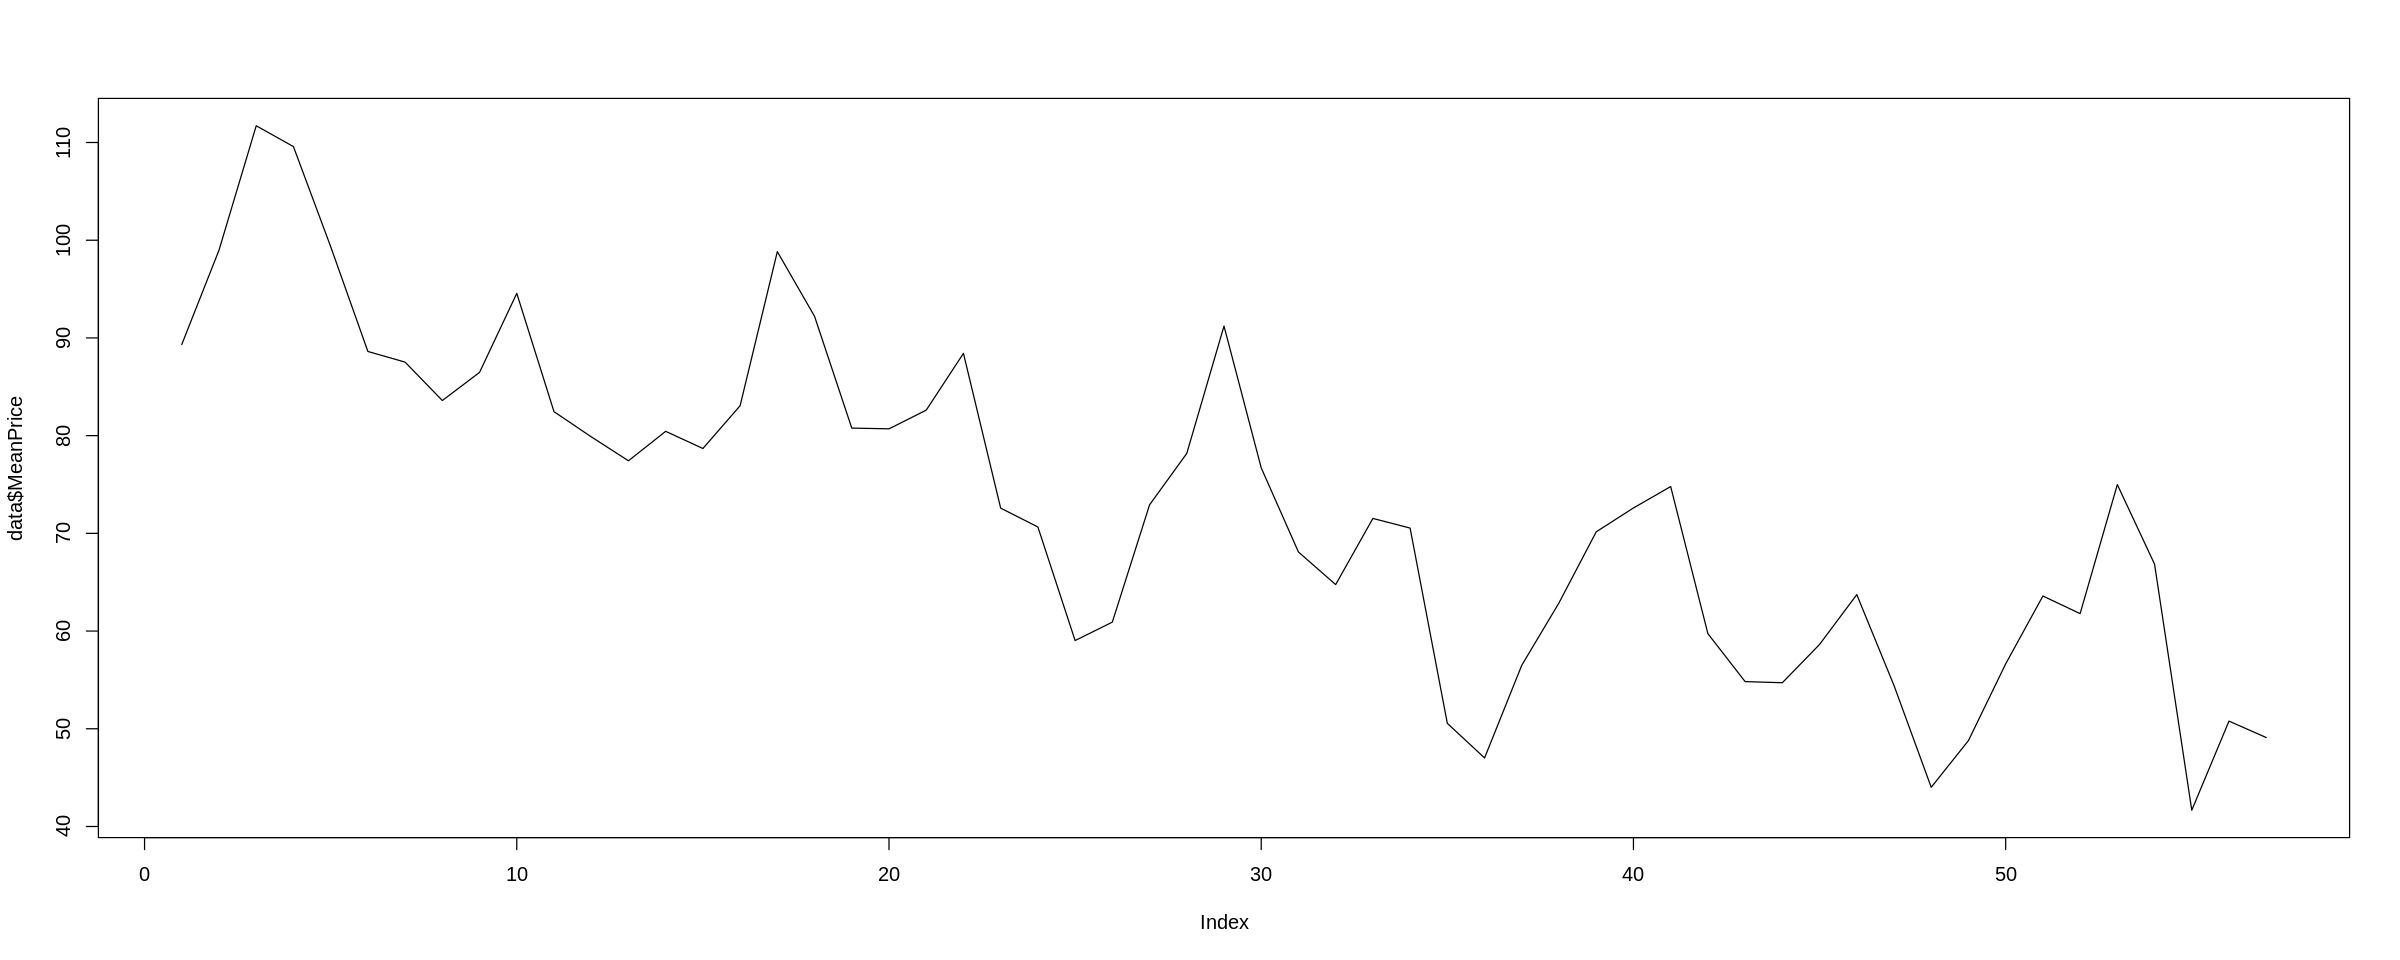

In [21]:
data = data %>% group_by(Year, Month) %>% summarise("MeanPrice" = mean(MinPrice)) %>% data.frame()

head(data)
plot(data$MeanPrice, type = 'l')

#### Creating sequence Time variable for Regression models

In [22]:
data$Time = 1:nrow(data)

#### Convert Month attribute to factor

It is used in future model for seasonality 

In [23]:
data$Month = as.factor(data$Month)

#### Remove Year attribute

It is not required further

In [24]:
data$Year = NULL

In [25]:
head(data)

,Month,MeanPrice,Time
,<fct>,<dbl>,<int>
1,4,89.33187,1
2,5,98.98226,2
3,6,111.71333,3
4,7,109.58000,4
5,8,99.34645,5
6,9,88.61500,6


## Data split: train and validation sets

In [26]:
dim(data)

[1] 57  3

In [27]:
train = data[1:53, ]
val = data[54:nrow(data), ]

In [28]:
train

,Month,MeanPrice,Time
,<fct>,<dbl>,<int>
1,4,89.33187,1
2,5,98.98226,2
3,6,111.71333,3
4,7,109.58000,4
5,8,99.34645,5
6,9,88.61500,6
7,10,87.52210,7
8,11,83.59500,8
9,12,86.47677,9


In [29]:
val

,Month,MeanPrice,Time
,<fct>,<dbl>,<int>
54,9,66.84800,54
55,10,41.66387,55
56,11,50.78450,56
57,12,49.10000,57


## Regression on Time

### Simple Linear Regression


In [30]:
lm1 = lm(MeanPrice ~ Time, data = train)

summary(lm1)


Call:
lm(formula = MeanPrice ~ Time, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.834  -5.766  -1.474   5.825  22.394 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 97.02243    2.61063  37.164  < 2e-16 ***
Time        -0.83822    0.08413  -9.964 1.46e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.369 on 51 degrees of freedom
Multiple R-squared:  0.6606,	Adjusted R-squared:  0.654 
F-statistic: 99.28 on 1 and 51 DF,  p-value: 1.459e-13


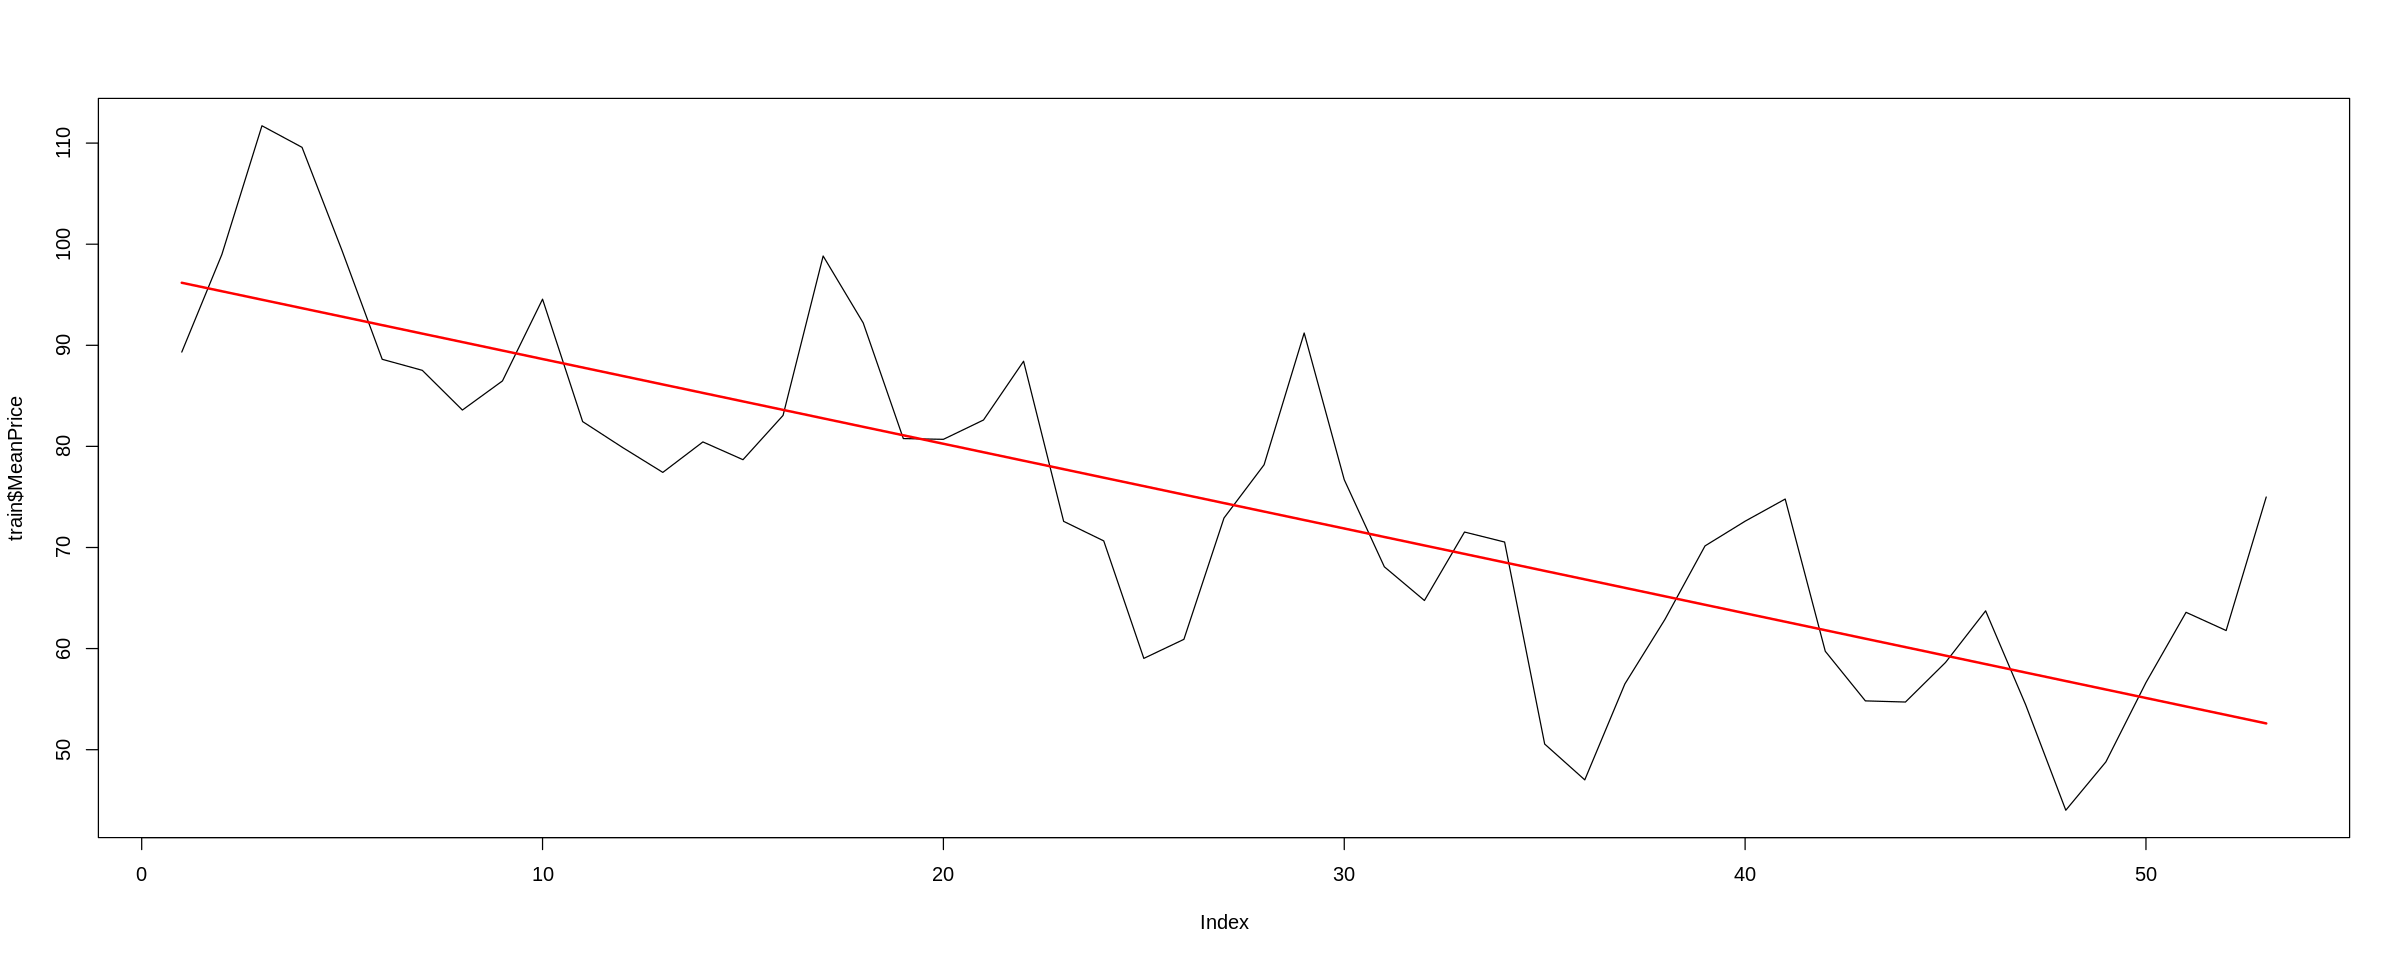

In [31]:
# Predict on train and validation 
pred_Train = predict(lm1)
pred_Val  = predict(lm1, val)

# plot the train data along with predictions
plot(train$MeanPrice, type = "l")
lines(train$Time, pred_Train, col = "red", lwd = 2)

#### Evaluate model performance

In [32]:
lm1TrainError = regr.eval(train$MeanPrice, pred_Train)
lm1ValError  = regr.eval(val$MeanPrice, pred_Val)

lm1TrainError
lm1ValError

mae        mse       rmse       mape 
 7.3604306 84.4599186  9.1902078  0.1050726

mae        mse       rmse       mape 
 6.2980475 78.4718183  8.8584320  0.1161648

### Linear Regression Model using Month Variable to capture seasonality

In [33]:
slm1 <- lm(MeanPrice~., data=train)

summary(slm1)


Call:
lm(formula = MeanPrice ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.0569  -2.8466   0.7989   2.9696  11.9076 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 103.10638    3.25374  31.689  < 2e-16 ***
Month2      -13.45867    4.10584  -3.278 0.002168 ** 
Month3      -17.22491    4.10684  -4.194 0.000147 ***
Month4      -15.64557    3.89800  -4.014 0.000255 ***
Month5       -9.03884    3.89623  -2.320 0.025534 *  
Month6       -0.75135    3.89517  -0.193 0.848020    
Month7        1.72902    3.89482   0.444 0.659488    
Month8        9.37220    3.89517   2.406 0.020836 *  
Month9       -3.39729    4.11086  -0.826 0.413470    
Month10      -9.05949    4.10852  -2.205 0.033262 *  
Month11     -10.07176    4.10684  -2.452 0.018648 *  
Month12      -5.35198    4.10584  -1.304 0.199855    
Time         -0.84976    0.05248 -16.192  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual

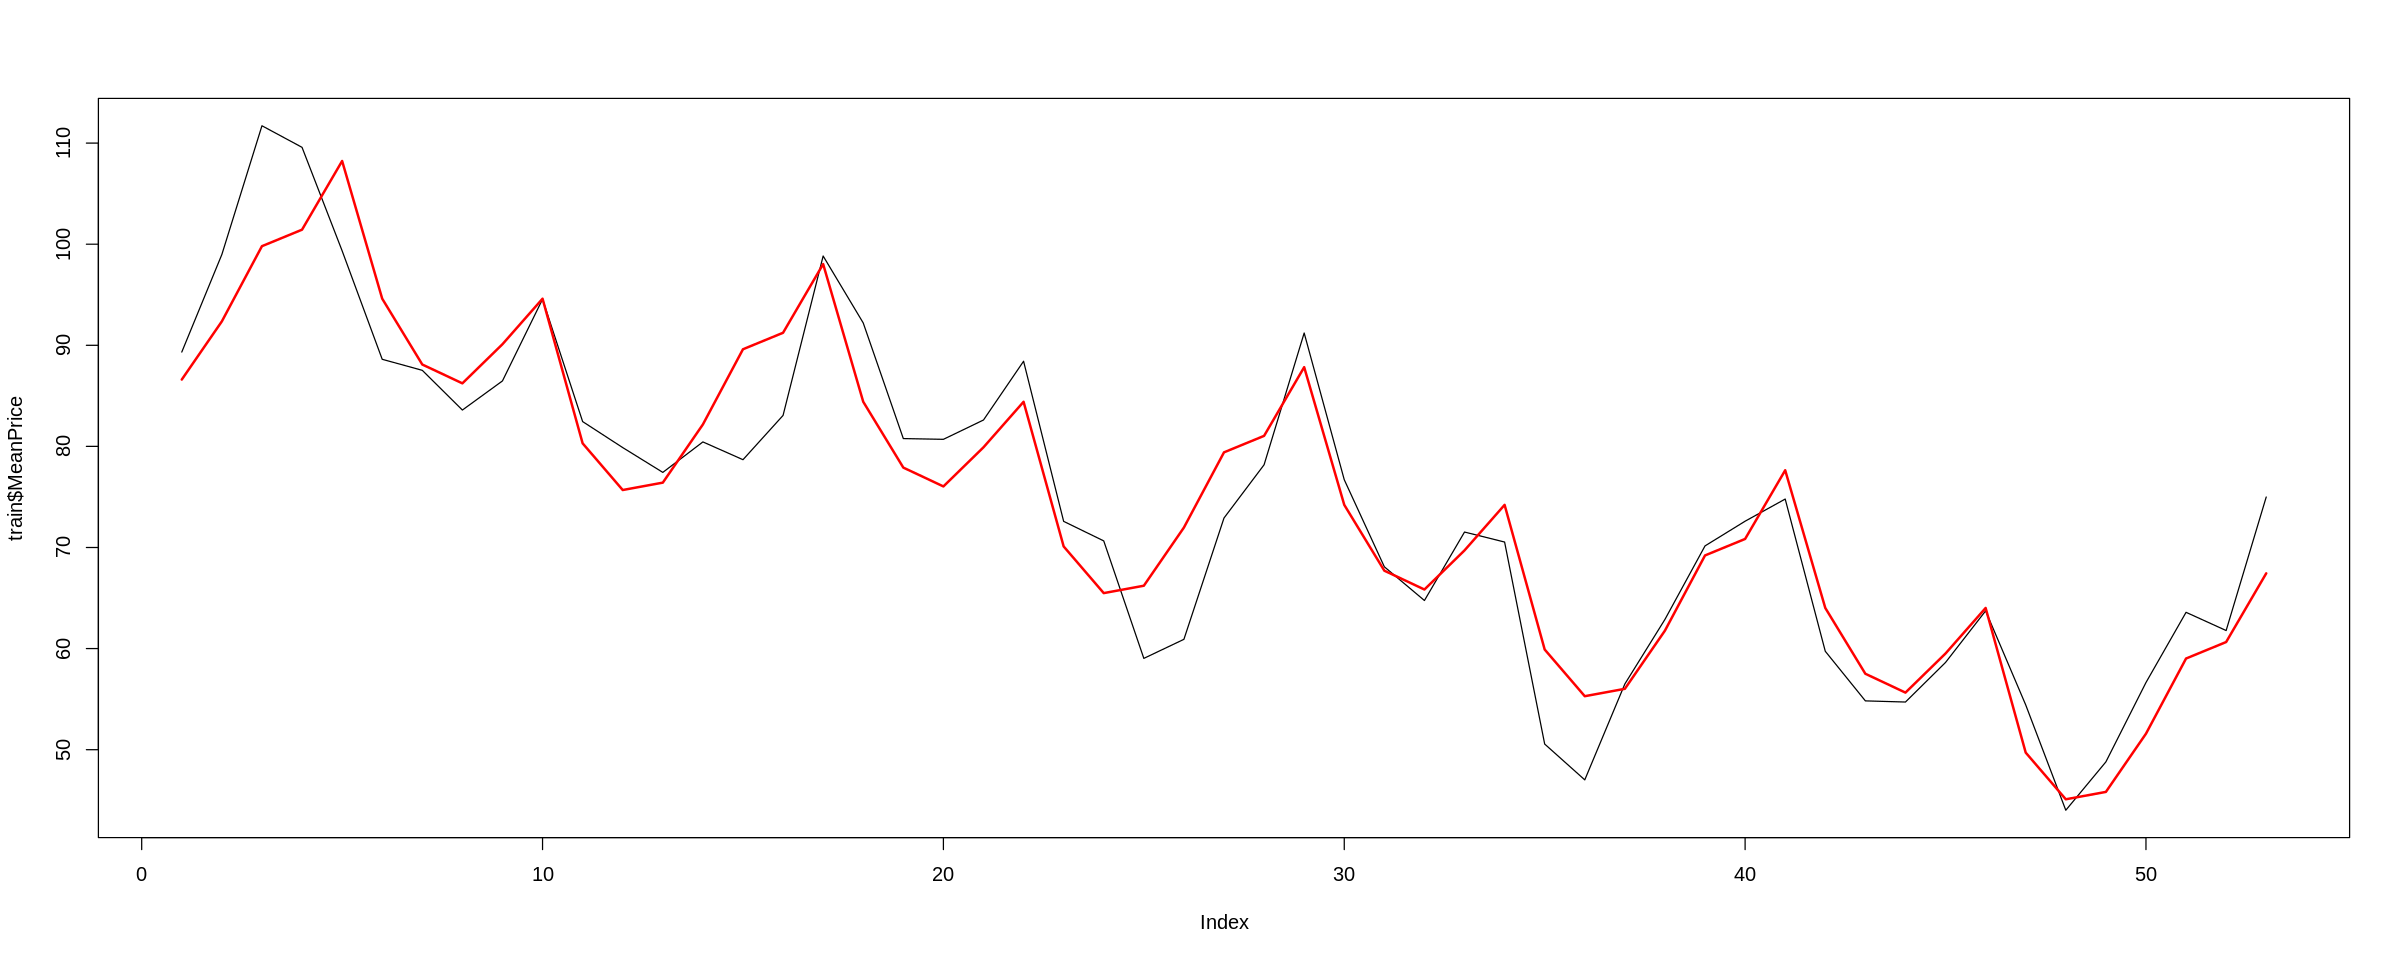

In [34]:
# Predict on train and test
pred_Train = predict(slm1)
pred_Val  = predict(slm1, val)

# plot the train data along with predictions
plot(train$MeanPrice, type="l")
points(train$Time, pred_Train, type="l", col="red", lwd=2)

#### Evaluate model performance

In [35]:
slm1TrainError = regr.eval(train$MeanPrice, pred_Train)
slm1ValError = regr.eval(val$MeanPrice, pred_Val)
slm1TrainError
slm1ValError

mae         mse        rmse        mape 
 3.98447730 25.44172377  5.04397896  0.05487652

mae        mse       rmse       mape 
 6.0566694 57.5215150  7.5842940  0.1099742

## Creating Time-Series Object

In [36]:
# Converting data into R time series object 
train_TS <- ts(train$MeanPrice, frequency = 12, start = c(2009, 4))
val_TS <- ts(val$MeanPrice, frequency = 12, start = c(2013, 9))

train_TS
# val_TS

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2009,,,,89.33187,98.98226,111.71333,109.58000,99.34645,88.61500,87.52210,83.59500,86.47677
2010,94.56161,82.45250,79.88065,77.42767,80.44161,78.68367,83.06452,98.83145,92.20900,80.77274,80.69867,82.61000
2011,88.42161,72.58196,70.64968,59.03067,60.91677,72.91667,78.18194,91.21645,76.70200,68.08935,64.75600,71.52661
2012,70.53839,50.55517,47.01290,56.50133,62.88645,70.15700,72.60000,74.79161,59.73300,54.82694,54.71333,58.62968
2013,63.73032,54.42857,44.01097,48.79200,56.64129,63.58633,61.78355,74.99113,,,,


#### Visualize the time series Data

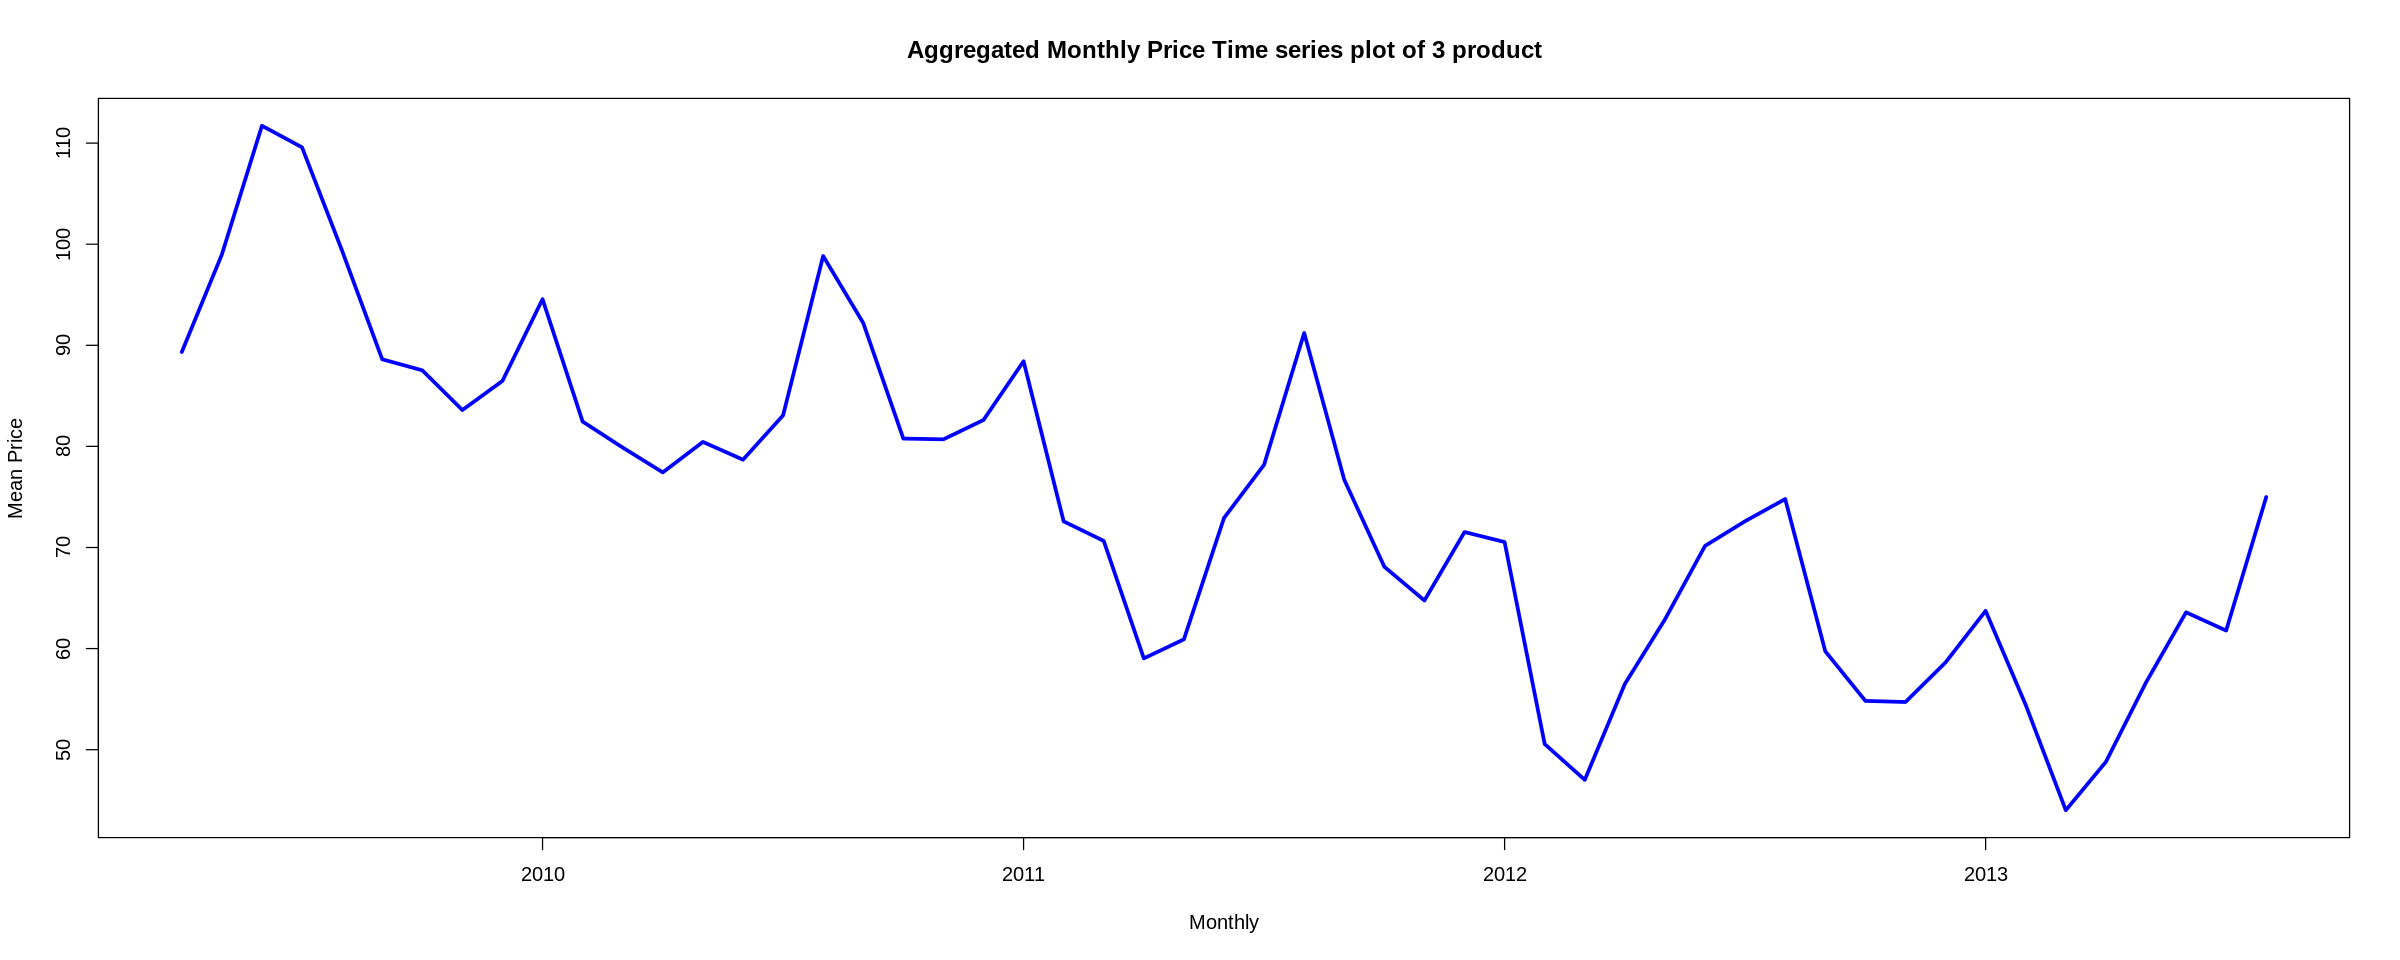

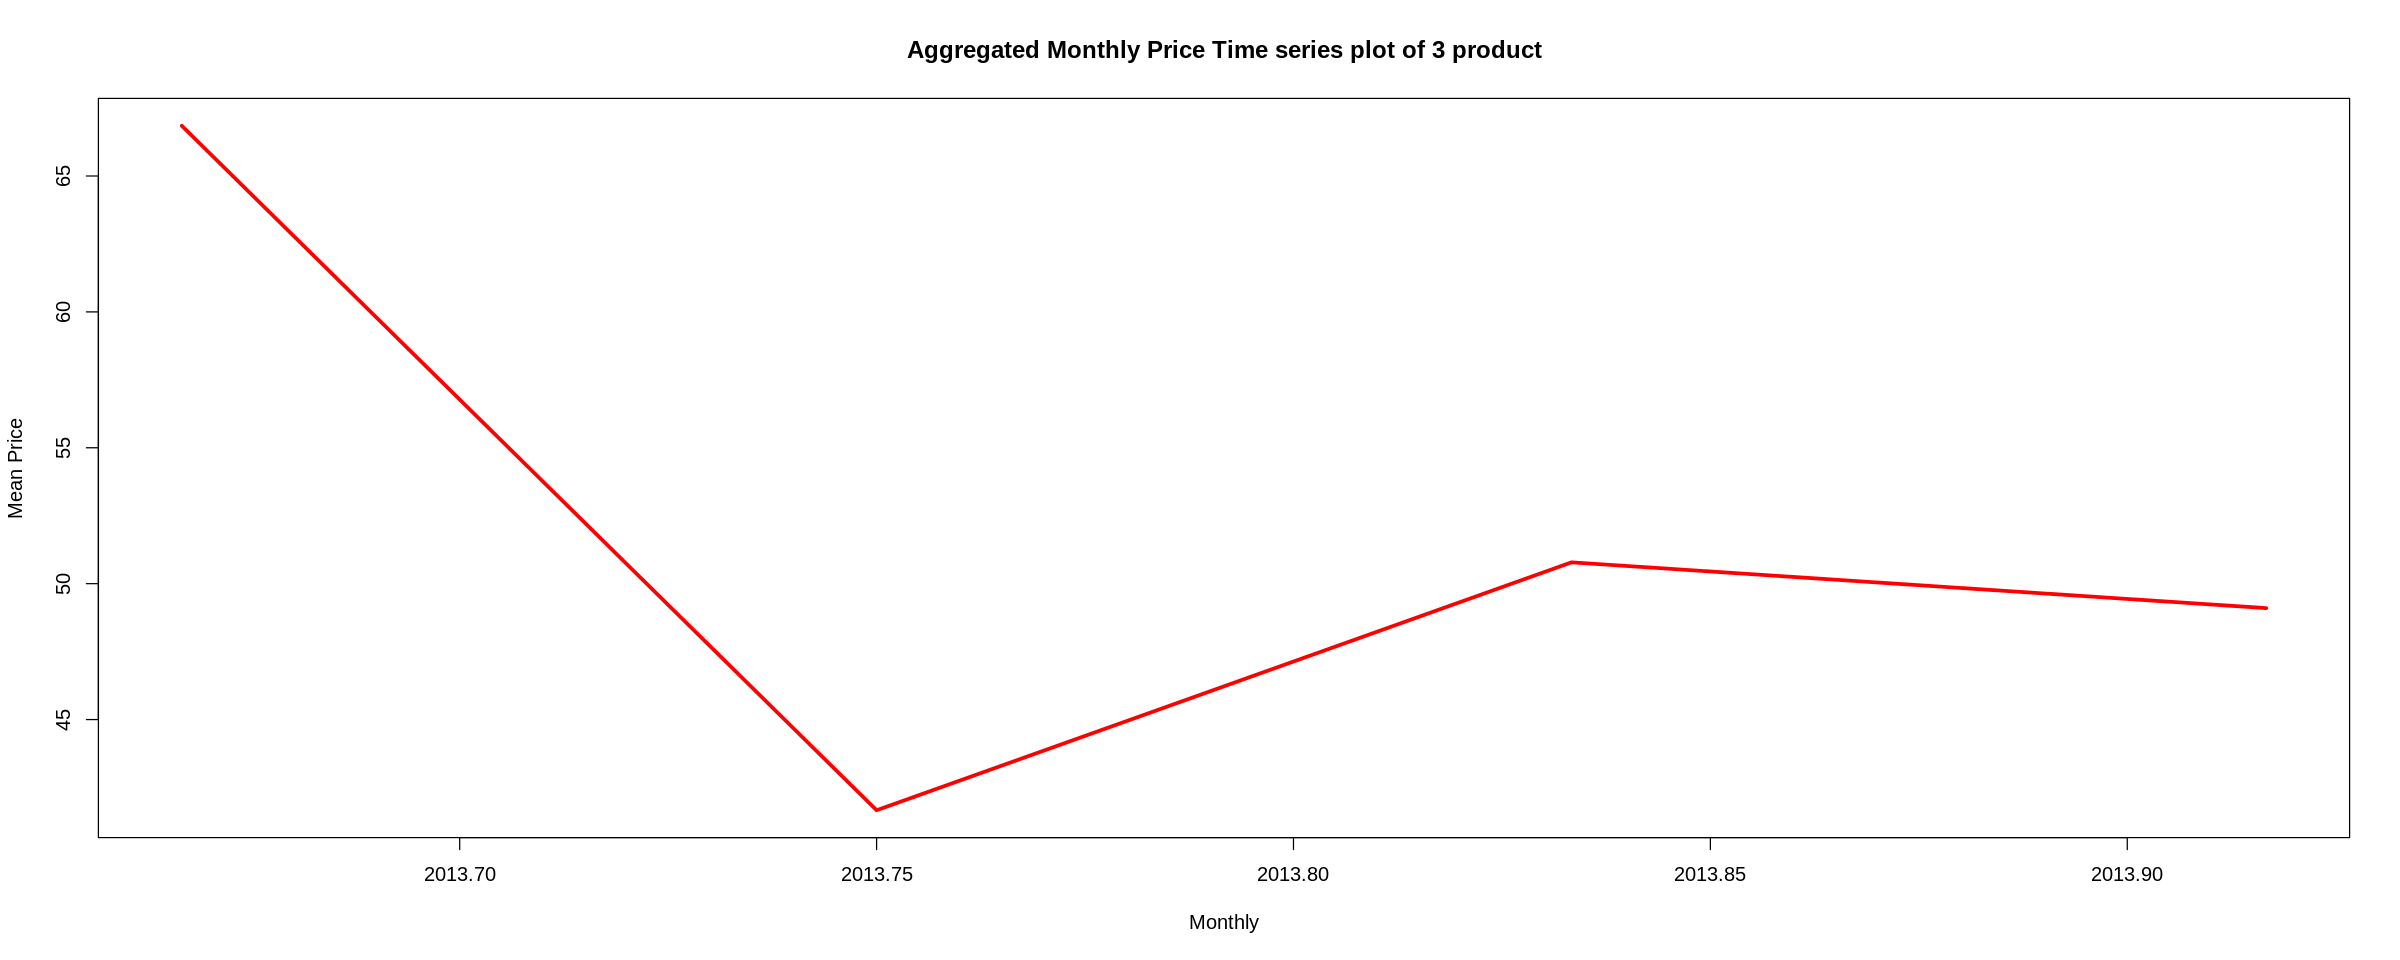

In [37]:
plot(train_TS, type="l", lwd=3, col="blue", 
     xlab="Monthly", ylab="Mean Price",
     main="Aggregated Monthly Price Time series plot of 3 product")

plot(val_TS, type="l", lwd=3, col="red", 
     xlab="Monthly", ylab="Mean Price",
     main="Aggregated Monthly Price Time series plot of 3 product")

## Moving Averages

#### Simple Moving Averages

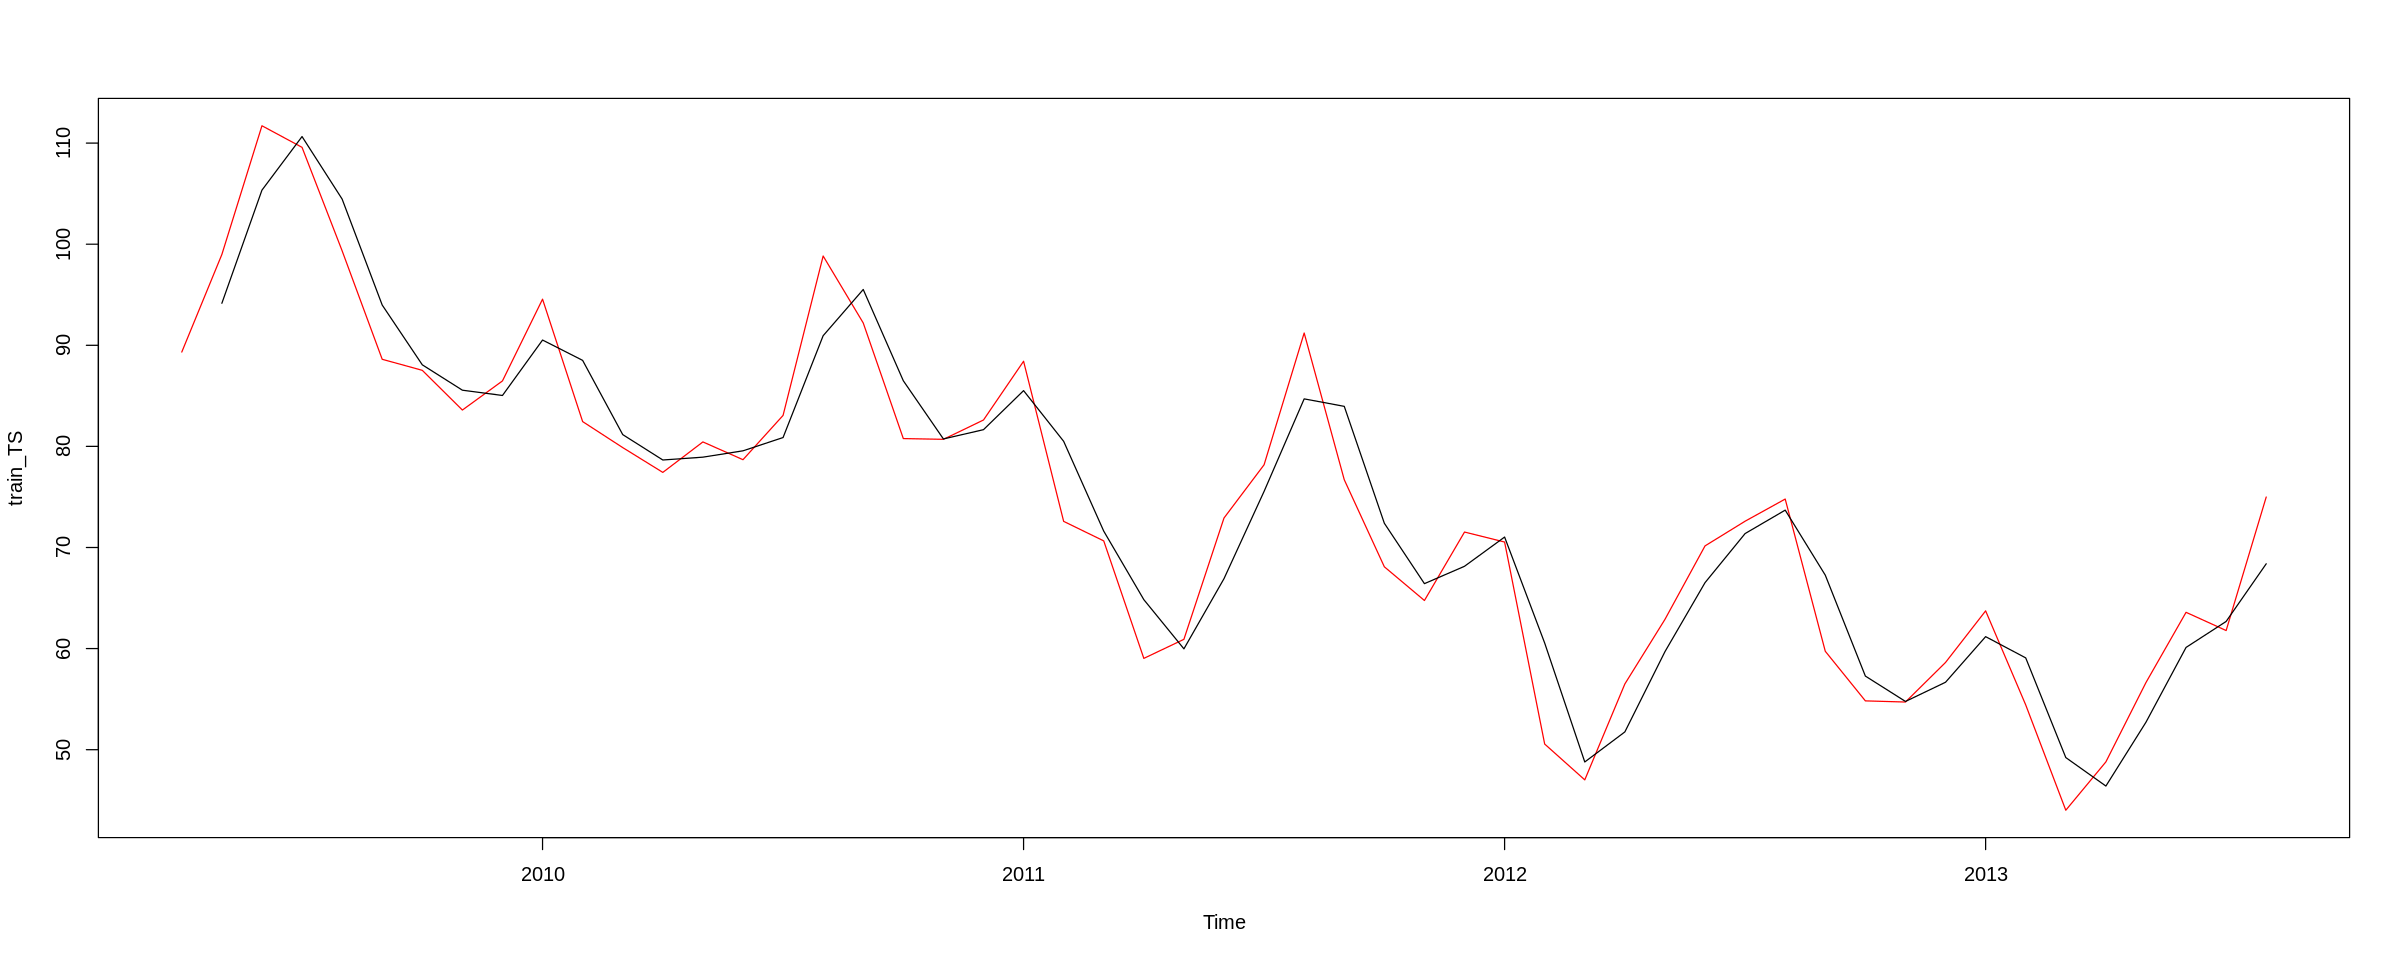

In [38]:
fitsma = SMA(train_TS, n=2)

plot(train_TS, col='red')
lines(fitsma,  col='black')

#### Weighted Moving Averages

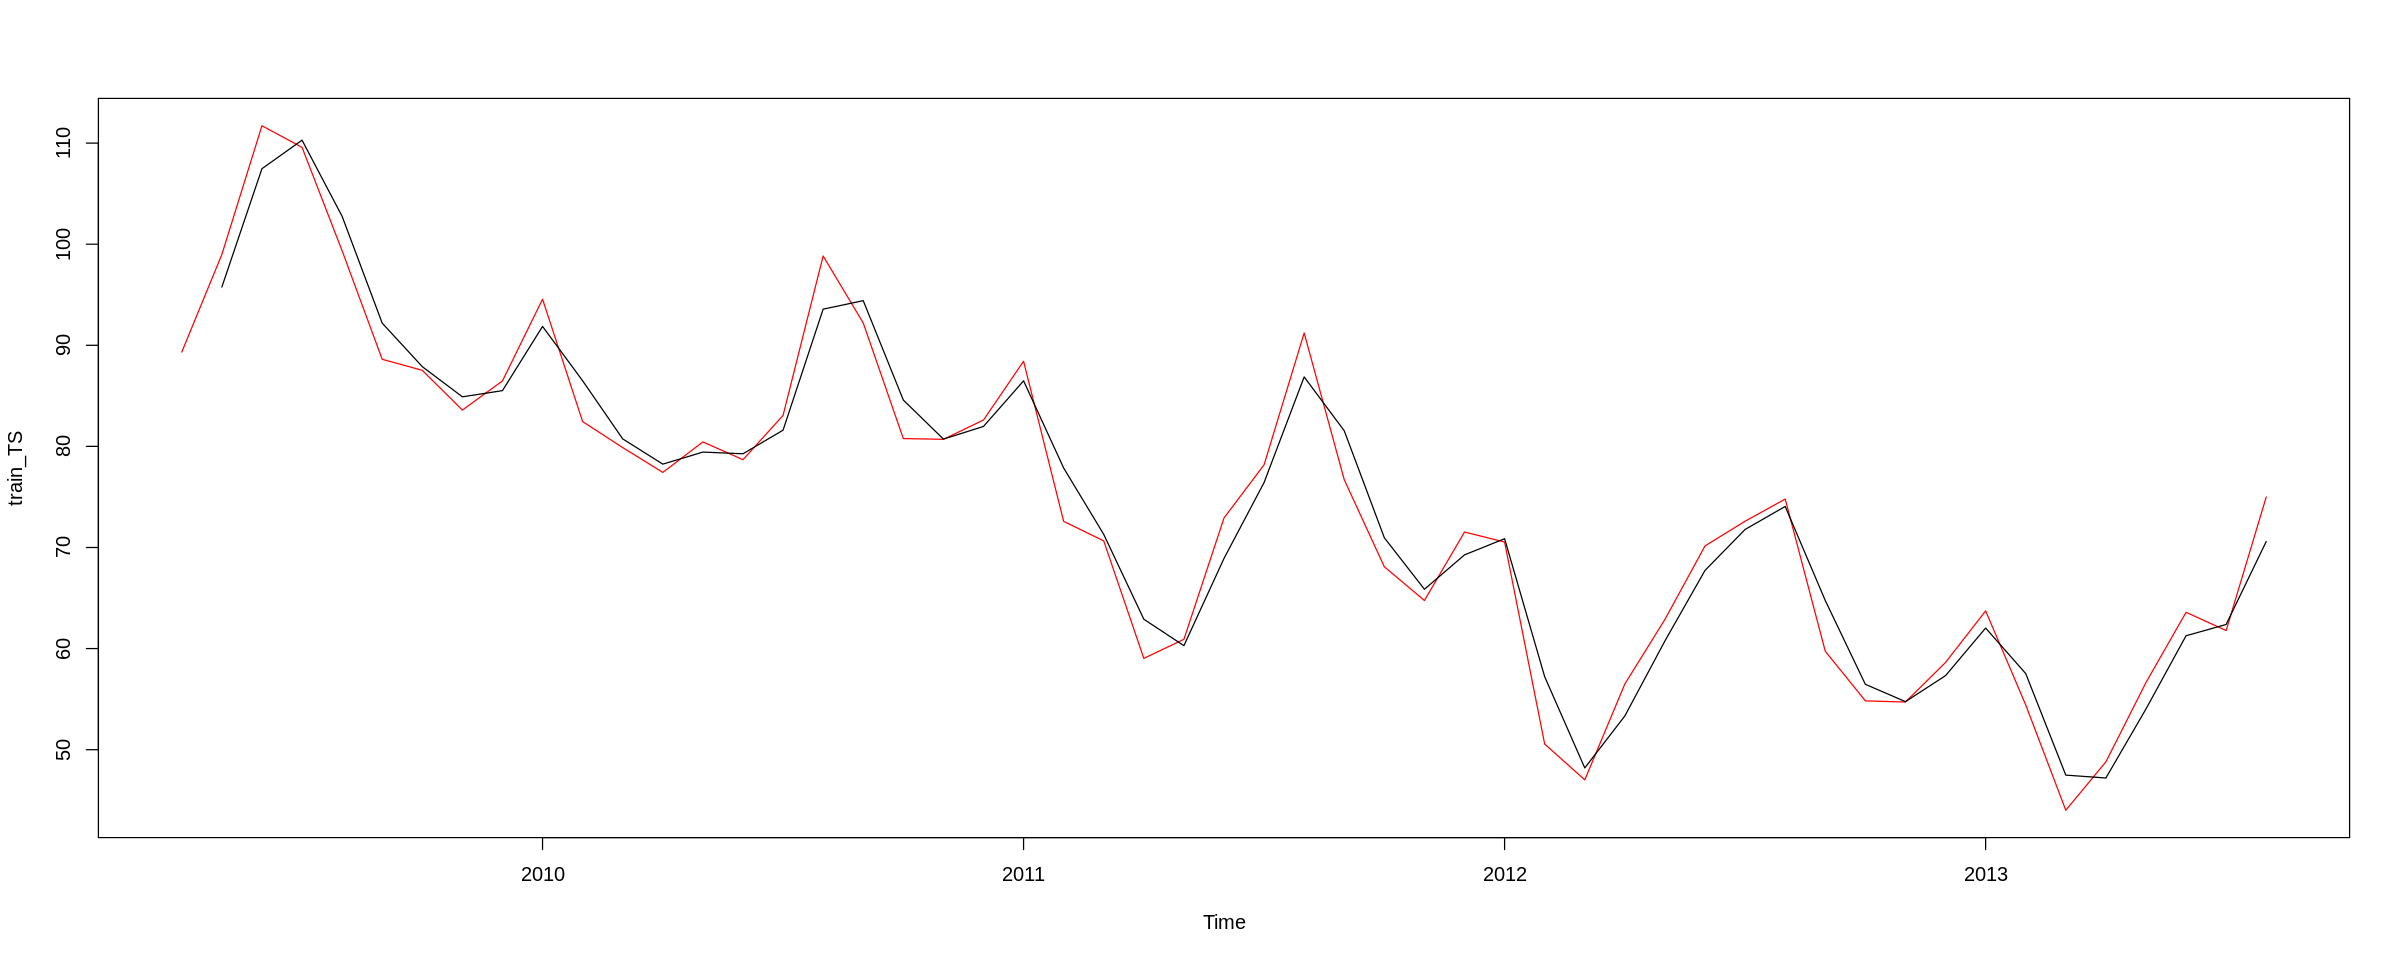

In [39]:
fitwma = WMA(train_TS, n=2, 1:2)

plot(train_TS, col='red')
lines(fitwma, col='black')

#### Simple Exponential Smoothing

In [ ]:
fitses = ses(train_TS, h=4)

plot(fitses)
summary(fitses)

#### Evaluate model performance

In [ ]:
pred_Train = fitses$fitted
pred_Val = forecast(fitses, h=4)

sesTrainError = regr.eval(train$MeanPrice, pred_Train)
sesValError = regr.eval(val$MeanPrice, pred_Val$mean)
sesTrainError
sesValError

## ETS Models 

In [ ]:
fitets = ets(train_TS)

plot(fitets)
summary(fitets)

In [ ]:
checkresiduals(fitets)

#### 𝐻_𝑜 : 𝑍𝑒𝑟𝑜 𝑐𝑜𝑟𝑟𝑒𝑙𝑎𝑡𝑖𝑜𝑛 𝑎𝑚𝑜𝑛𝑔 𝑟𝑒𝑠𝑖𝑑𝑢𝑎𝑙𝑠
#### 𝐻_𝑎 : 𝑆𝑖𝑔𝑛𝑖𝑓𝑖𝑐𝑎𝑛𝑡 𝑐𝑜𝑟𝑟𝑒𝑙𝑎𝑡𝑖𝑜𝑛 𝑎𝑚𝑜𝑛𝑔 𝑟𝑒𝑠𝑖𝑑𝑢𝑎𝑙𝑠

#### Evaluate model performance

In [ ]:
forecast_ets = forecast(fitets, h=4)
val_pred = forecast_ets

regr.eval(train_TS, fitets$fitted)
regr.eval(val_TS, val_pred$mean)

## Auto Arima

In [ ]:
ARIMA_auto = auto.arima(train_TS)
summary(ARIMA_auto)

#### Check ACF plot

In [ ]:
Acf(ARIMA_auto$residuals)

#### Box-Ljung Test

- Null Hypothesis         
        - Errors are not correlated
- Alternative Hypothesis  
        - Errors are correlated

In [ ]:
Box.test(ARIMA_auto$residuals, type="Ljung-Box")

#### Evaluate model performance

In [ ]:
pred_Train = fitted(ARIMA_auto)
pred_Val = forecast(ARIMA_auto, h = 4)

regr.eval(train_TS, pred_Train)
regr.eval(val_TS, data.frame(pred_Val)$Point.Forecast)